## imports


In [ ]:
# !ls /datasets/aurora

In [2]:
!sudo apt remove -y python3-numpy python3-scipy
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124
!pip install cdsapi dask xarray netcdf4 matplotlib microsoft-aurora boto3 awscli
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!pip install scikit-learn
!git config --global --add safe.directory /home/ubuntu/globfire-gooddata
# !pip install --upgrade numpy scipy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 GB 4.7 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 130.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 174.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 226.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 57.2 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 159.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 159.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━

tthe next two boxes are used for using aws cli 

In [5]:
!aws --version

aws-cli/1.36.22 Python/3.10.12 Linux/6.8.0-1013-nvidia-64k botocore/1.35.81


In [ ]:
# see awsid

In [15]:
import xarray as xr
from tqdm import tqdm
from aurora import Batch, Metadata
import os
import glob
import re
import boto3
from io import BytesIO
import io
import pandas as pd
import torch.nn.functional as F
from aurora import Aurora
from aurora.normalisation import locations, scales
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch
import sklearn
import numpy as np
import gc
# from netCDF4 import Dataset
# import h5py
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


True

## importing data

In [ ]:
# see awsid for missing line

# bucket_name = 'globfire-gooddata'
# compression_settings = {'zlib': True, 'complevel': 3}

# surf_comb = xr.open_mfdataset(surf_files, combine='nested')
# encoding_surf = {var: compression_settings for var in surf_comb.data_vars}
# surf_comb.to_netcdf("surf_comb.nc", encoding=encoding_surf)
# s3.upload_file("surf_comb.nc", bucket_name, "surf_comb.nc")

code for joinging 3 days worth of data together to feed into aurora

In [ ]:
download_path = "datasets/aurora"
surf_path = f"../{download_path}/fle"
atmos_path = f"../{download_path}/atmospheric"

static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
atmos_files_2021 = [f for f in atmos_files if int(f.split('/')[-2]) <= 202112]
surf_files = glob.glob(f"../{download_path}/fle/*.nc") 

In [ ]:
starty = 2015     ## start of 2015 to end of 2021
endy = 2021           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')

download_path = "datasets/aurora"
surf_path = f"../{download_path}/fle"
atmos_path = f"../{download_path}/atmospheric"

atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
# atmos_files = glob.glob(f"../{download_path}/atmospheric/(201[0-9][0-9]{2}|202(0|1)[0-9]{2})/*.nc")  
atmos_files_2021 = [f for f in atmos_files if int(f.split('/')[-2]) <= 202112]
surf_files = glob.glob(f"../{download_path}/fle/*.nc") 


days = 3

# ./datasets/aurora/atmospheric/201501/atmospheric_20150111.nc'
#../datasets/aurora/fle/surf_2021-11-17.nc'

In [ ]:
i=0
date_range[i:i + days]

## basic one day batch

In [7]:
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']
date_range = pd.date_range(start=f'{2015}-01-01', end=f'{2015}-1-03', freq='D')
days = 1
for i in tqdm(range(len(date_range) - days + 1), desc = "data loading"):
    date_window = date_range[i:i + days]
    
    atmos_regex = []
    surf_regex = []
    for day in range(days):
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))
    
    atmos_filt = [f for f in atmos_files_2021 if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]

    print(atmos_filt)
    print(surf_filt)
    
    
    atmos_list = []
    surf_list = []
    
    for day in range(len(atmos_filt)):
        atmos_cur = xr.open_dataset(atmos_filt[day])
        surf_cur = xr.open_dataset(surf_filt[day])
        
        # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
        surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

        atmos_list.append(atmos_cur)
        surf_list.append(surf_cur)
    
    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    
static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")

data loading:   0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'atmos_files_2021' is not defined

In [ ]:

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
        "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

In [ ]:
# static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
# surf_vars_ds = xr.open_dataset(f"../{download_path}/fle/surf_2015-01-04.nc", engine="netcdf4")
# atmos_vars_ds = xr.open_dataset(f"../{download_path}/atmospheric/201501/atmospheric_20150104.nc", engine="netcdf4")


j = i+1  # Select this time index in the downloaded data.

surf_size = (720, 1440)
atmos_size = (720, 1440)

surf_vars={
    # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
    # batch dimension of size one.
    "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
    "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
    "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
    "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
    "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
    "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
}
static_vars={
    # The static variables are constant, so we just get them for the first time.
    "z": torch.from_numpy(static_vars_ds["z"].values[0]),
    "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
    "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
}
atmos_vars={
    "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
    "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
    "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
    "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
    "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
}

output_size = (720, 1440)

interpolated_surf_vars = {
    key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
    for key, value in surf_vars.items()
}

interpolated_atmos_vars = {
    key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
    for key, value in atmos_vars.items()
}

interpolated_static_vars = {
    key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=output_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    for key, value in static_vars.items()
}


batch2 = Batch(
    surf_vars = interpolated_surf_vars,
    static_vars=interpolated_static_vars,
    atmos_vars=interpolated_atmos_vars,
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

## convert to dataset and dataloader 

In [6]:

# using surf_comb is not the best solution
# lstdata = torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None])
# Normalisation means:
locations["fire"] = 0.0
locations["lst"] = 11484.10859

# Normalisation standard deviations:
scales["fire"] = 1.0
scales["lst"] = 8109.33224

In [7]:
def data_retreive ( atmos_files, surf_files, date_range, days, idx , variables_to_keep = None ):
    date_window = date_range[idx:idx + days]

    atmos_regex = []
    surf_regex = []
    for day in range(days):
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))

    atmos_filt = [f for f in atmos_files if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]
    atmos_list = []
    surf_list = []

    for day in range(len(atmos_filt)):
        with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :

            # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
            if variables_to_keep is not None:
                surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

            atmos_list.append(atmos_cur.load())
            surf_list.append(surf_cur.load())

    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    return atmos_comb, surf_comb


In [8]:
def feature_label_batch(atmos_comb, surf_comb, static, interpolated_static_vars):
    i = 1  
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
            "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
            "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
        },
        # static_vars={
        #     # The static variables are constant, so we just get them for the first time.
        #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        # },
        static_vars=static ,
        atmos_vars={
            "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        )
        # metadata=metadata
    )
    
    j = 2  # Select this time index in the downloaded data.

    surf_size = (720, 1440)
    atmos_size = (720, 1440)

    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
        # ************** Comment out LST
        "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
    }
    # static_vars={
    #     # The static variables are constant, so we just get them for the first time.
    #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
    #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
    #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    # }
    # static_vars=static 
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
    }

    output_size = (720, 1440)

    interpolated_surf_vars = {
        key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }

    interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }

    # interpolated_static_vars = {
    #     key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=output_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    #     for key, value in static_vars.items()
    # }


    batch2 = Batch(
        surf_vars = interpolated_surf_vars,
        static_vars=interpolated_static_vars,
        atmos_vars=interpolated_atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[j],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        ),
        # metadata=metadata
    )
    return batch, batch2

In [9]:
class AuroraDataset(Dataset):
    def __init__(self, download_path, variables_to_keep , starty, endy):
        """
        Args:
            folder_path (str): Path to the folder containing the daily files.
            transform (callable, optional): A function/transform to apply to the data.
        """
        with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds:
            self.static={
                # The static variables are constant, so we just get them for the first time.
                "z": torch.from_numpy(static_vars_ds["z"].values[0]),
                "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
                "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
            }
            self.interp_static = {
                key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                for key, value in self.static.items()
            }
        self.atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
        self.surf_files = glob.glob(f"../{download_path}/fle/*.nc") 
        
        self.window = 3
        self.variables_to_keep = variables_to_keep
        
        self.date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
        
        # self.file_names = sorted(os.listdir(folder_path))  # Sort to ensure correct order
        # self.transform = transform

    def __len__(self):
        """Returns the total number of files (days)."""
        return len(self.surf_files) - self.window + 1

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the file to load.
        Returns:
            (Tensor, Tensor): Features and labels for the given day.
        """
#         file_path = os.path.join(self.folder_path, self.file_names[idx])
        
        #                       
        atmos, surf = data_retreive(self.atmos_files, self.surf_files, self.date_range
                             , self.window, idx, self.variables_to_keep)
        
        # metadata=Metadata(
        #     lat=torch.from_numpy(surf.latitude.values),
        #     lon=torch.from_numpy(surf.longitude.values),
        #     # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        #     # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        #     # one value for every batch element.
        #     time=(surf.valid_time.values.astype("datetime64[s]").tolist()[1],),
        #     atmos_levels=tuple(int(level) for level in atmos.pressure_level.values),
        # )
        # Assuming the last column is the label
        features, labels = feature_label_batch(atmos, surf, self.static, self.interp_static)
         # = label_batch(atmos, surf, self.interp_static, metadata) # metadata technically wrong for labels

        # Convert to tensors
        return (
            features, labels
        )


In [10]:
def aurora_collate(batch):
    """
    Custom collate function for handling Batch objects as features and labels.

    Args:
        batch (list of tuples): Each tuple contains (features, labels), where
                                features and labels are instances of `Batch`.

    Returns:
        Batched features and labels.
    """
    # Separate features and labels from the batch
    features_list, labels_list = zip(*batch)

    # Function to batch the variables in each component of the `Batch` object
    def collate_batch_components(batch_list, key):
        return {
            var_key: torch.stack([getattr(b, key)[var_key] for b in batch_list])
            for var_key in getattr(batch_list[0], key)}

    # Combine `surf_vars` and `atmos_vars` for features and labels
    batched_features = Batch(
        surf_vars=collate_batch_components(features_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(features_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([f.metadata.lat for f in features_list]),
            lon=torch.stack([f.metadata.lon for f in features_list]),
            time=[f.metadata.time for f in features_list],
            atmos_levels=[f.metadata.atmos_levels for f in features_list],
        ),
    )

    batched_labels = Batch(
        surf_vars=collate_batch_components(labels_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(labels_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([l.metadata.lat for l in labels_list]),
            lon=torch.stack([l.metadata.lon for l in labels_list]),
            time=[l.metadata.time for l in labels_list],
            atmos_levels=[l.metadata.atmos_levels for l in labels_list],
        ),
    )

    return features_list[0], labels_list[0]


## run as single block

In [14]:
# Normalisation means:
# locations["fire"] = 0.0
# locations["lst"] = 11484.10859

# Normalisation standard deviations:
# scales["fire"] = 1.0
# scales["lst"] = 8109.33224

# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

def data_retreive ( atmos_files, surf_files, date_range, days, idx , variables_to_keep = None ):
    date_window = date_range[idx:idx + days]
    # print(date_range)
    # print(idx)
    # print(days)
    atmos_regex = []
    surf_regex = []
    for day in range(days):
        # note that no need to look at download path here because its already accounted for when globing inside of aurora dataset
        # atmos_regex.append( re.compile( rf"\.\./{download_path}/atmospheric/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        # surf_regex.append( re.compile( rf"\.\./{download_path}/fle/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))
        # atmos_regex.append( re.compile( rf".*/{download_path}.*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        # surf_regex.append( re.compile( rf".*/{download_path}.*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))

    atmos_filt = [f for f in atmos_files if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]
    atmos_list = []
    surf_list = []
    # print(atmos_filt)
    # print("surf")
    # print(surf_filt)
    ds = xr.open_dataset(atmos_filt[0]).load()
    ds.close()

    # for day in range(len(atmos_filt)):
    for day in range(days):
        # surf_cur = None  # Initialize to None
        # atmos_cur = None  # Initialize to None
        # print(atmos_filt[day])
        # with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :
        # try: 
        # with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :
        with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :
            # atmos_cur = xr.open_dataset(atmos_filt[day])
            # surf_cur = xr.open_dataset(surf_filt[day])
        

            # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
            if variables_to_keep is not None:
                surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

            atmos_list.append(atmos_cur.load())
            surf_list.append(surf_cur.load())
            
        # finally: 
        #     if atmos_cur is not None:
        #         atmos_cur.close()
        #     if surf_cur is not None:
        #         surf_cur.close()

    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    return atmos_comb, surf_comb

def feature_label_batch(atmos_comb, surf_comb, static, interpolated_static_vars):
    i = 1  
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
            "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
            "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
        },
        # static_vars={
        #     # The static variables are constant, so we just get them for the first time.
        #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        # },
        static_vars=static ,
        atmos_vars={
            "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        )
        # metadata=metadata
    )
    
    # print(np.unique(batch.surf_vars["fire"].cpu().numpy()))
    
    j = 2  # Select this time index in the downloaded data.

    surf_size = (720, 1440)
    atmos_size = (720, 1440)

    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
        # ************** Comment out LST
        "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
    }
    # print(np.unique(surf_vars["fire"].cpu().numpy()))
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
    }

    output_size = (720, 1440)


    interpolated_surf_vars = {
        key: (F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }

    # interpolated_surf_vars = {
    #     key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
    #     for key, value in surf_vars.items()
    # }

    # used to check interpolation having a good cutoff value
    # print(surf_vars["fire"].squeeze(0).squeeze(0).shape)
    # print("before count", surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    # print("after count", interpolated_surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    
    interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }

    batch2 = Batch(
        surf_vars = interpolated_surf_vars,
        static_vars=interpolated_static_vars,
        atmos_vars=interpolated_atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[j],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        ),
        # metadata=metadata
    )
    return batch, batch2

class AuroraDataset(Dataset):
    def __init__(self, download_path, variables_to_keep , date_range):
        """
        Args:
            folder_path (str): Path to the folder containing the daily files.
            transform (callable, optional): A function/transform to apply to the data.
        """
        # self.sumides = 5
        # with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds :
        #     # static_vars_ds = pstatic_vars_ds
            
        #     prestatic={
        #         # The static variables are constant, so we just get them for the first time.
        #         "z": torch.from_numpy(np.copy(static_vars_ds["z"].values[0])),
        #         "slt": torch.from_numpy(np.copy(static_vars_ds["slt"].values[0])),
        #         "lsm": torch.from_numpy(np.copy(static_vars_ds["lsm"].values[0])),
        #     }
        #     # prestatic={
        #     #     # The static variables are constant, so we just get them for the first time.
        #     #     "z": torch.from_numpy(static_vars_ds["z"].values[0].copy()),
        #     #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0].copy()),
        #     #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0].copy()),
        #     # }
        #     print(prestatic)
        #     self.static= prestatic
        #     self.interp_static = {
        #         key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        #         for key, value in prestatic.items()
        #     }

        # static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
        # static={
        #         # The static variables are constant, so we just get them for the first time.
        #         "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #         "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #         "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        #     }
        # self.interp_static = {
        #         key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        #         for key, value in static.items()
        #     }
        # static_vars_ds.close()

        
        with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds:
            self.static={
                # The static variables are constant, so we just get them for the first time.
                "z": torch.from_numpy(static_vars_ds["z"].values[0]),
                "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
                "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
            }
            self.interp_static = {
                key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                for key, value in self.static.items()
            }
            
        self.atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
        self.surf_files = glob.glob(f"../{download_path}/fle/*.nc") 
        
        self.window = 3
        self.variables_to_keep = variables_to_keep
        
        self.date_range = date_range
        self.download_path = download_path
        
        # self.file_names = sorted(os.listdir(folder_path))  # Sort to ensure correct order
        # self.transform = transform

    def __len__(self):
        """Returns the total number of files (days)."""
        # return len(self.surf_files) - self.window + 1
        return len(date_range) - self.window + 1

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the file to load.
        Returns:
            (Tensor, Tensor): Features and labels for the given day.
        """
#         file_path = os.path.join(self.folder_path, self.file_names[idx])
        
        #                       
        atmos, surf = data_retreive(self.atmos_files, self.surf_files, self.date_range
                             , self.window, idx,  self.variables_to_keep)
        
        # metadata=Metadata(
        #     lat=torch.from_numpy(surf.latitude.values),
        #     lon=torch.from_numpy(surf.longitude.values),
        #     # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        #     # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        #     # one value for every batch element.
        #     time=(surf.valid_time.values.astype("datetime64[s]").tolist()[1],),
        #     atmos_levels=tuple(int(level) for level in atmos.pressure_level.values),
        # )
        # Assuming the last column is the label
        features, labels = feature_label_batch(atmos, surf, self.static, self.interp_static)
         # = label_batch(atmos, surf, self.interp_static, metadata) # metadata technically wrong for labels
        
        # print("in getitem feature:", np.unique(features.surf_vars["fire"].cpu().numpy()))
        # print("in getitem label:", np.unique(labels.surf_vars["fire"].cpu().numpy()))
        # Convert to tensors
        return (
            features, labels
        )

def aurora_collate(batch):
    """
    Custom collate function for handling Batch objects as features and labels.

    Args:
        batch (list of tuples): Each tuple contains (features, labels), where
                                features and labels are instances of `Batch`.

    Returns:
        Batched features and labels.
    """
    # Separate features and labels from the batch
    features_list, labels_list = zip(*batch)

    # Function to batch the variables in each component of the `Batch` object
    def collate_batch_components(batch_list, key):
        return {
            var_key: torch.stack([getattr(b, key)[var_key] for b in batch_list])
            for var_key in getattr(batch_list[0], key)}

    # Combine `surf_vars` and `atmos_vars` for features and labels
    batched_features = Batch(
        surf_vars=collate_batch_components(features_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(features_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([f.metadata.lat for f in features_list]),
            lon=torch.stack([f.metadata.lon for f in features_list]),
            time=[f.metadata.time for f in features_list],
            atmos_levels=[f.metadata.atmos_levels for f in features_list],
        ),
    )

    batched_labels = Batch(
        surf_vars=collate_batch_components(labels_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(labels_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([l.metadata.lat for l in labels_list]),
            lon=torch.stack([l.metadata.lon for l in labels_list]),
            time=[l.metadata.time for l in labels_list],
            atmos_levels=[l.metadata.atmos_levels for l in labels_list],
        ),
    )

    return features_list[0], labels_list[0]


## dataset/loader testing

In [5]:
starty = 2015     ## start of 2015 to end of 2021
endy = 2021           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

download_path = "datasets/aurora"


dataset = AuroraDataset(download_path, variables_to_keep , starty, endy)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)

TypeError: AuroraDataset.__init__() takes 4 positional arguments but 5 were given

In [ ]:
for features, labels in dataloader:
    print(features.surf_vars["2t"].shape)  # Ensure shapes are correct
    print(labels.surf_vars["2t"].shape)
    break

In [ ]:
for batch_data, batch_labels in dataloader:
    print(batch_labels)

In [ ]:
# testing cell

print(batch.surf_vars['2t'].size())
print(interpolated_surf_vars['2t'].size())
print(interpolated_atmos_vars['t'].size())

# print(.size())
# print(f" size: {.size()}")
print(atmos_vars['t'].view(-1, 1, 721, 1440).size())
print(atmos_vars['t'].view(-1, 1, 721, 1440).shape[2])

# interpolated_surf_vars
# surf_vars

# print(atmos_vars['t'].size())
# print(atmos_vars['u'].size())
# print(atmos_vars['v'].size())
# print(atmos_vars['q'].size())
# print(atmos_vars['z'].size())
# torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None])

print(static_vars['z'].unsqueeze(0).unsqueeze(0).squeeze(0).size())

# atmos_vars.items()
print(batch2.surf_vars['2t'].size())
print(interpolated_surf_vars['2t'].size())
batch2.surf_vars['2t']

print(f"batch2 size: {batch2.surf_vars['2t'].size()}")
print(f"pred size: {pred.surf_vars['2t'].size()}")
batch2.surf_vars['2t']

In [ ]:
# interpolated_surf_vars['2t']
# pred.surf_vars['2t']
batch.surf_vars['2t']

In [ ]:
test =  torch.from_numpy(surf_vars_ds["lst"].values[[i - 1, i]][None])
test.mean()
test.std()

## model 

In [5]:
device = "cuda"

def loss_func(batch, pred):
    crit = nn.L1Loss()
    batch = batch.to('cuda')
    pred = pred.to('cuda')
    v_w = {}
    alpha = 0.25
    beta = 1
    dataset_weight = 2
    total_vars = len(batch.surf_vars) + len(batch.atmos_vars)
    v_w["2t"] = 3.0
    v_w["10u"] = 0.77
    v_w["10v"] = 0.66
    v_w["msl"] = 1.5
    v_w["z"] = 2.8
    v_w["q"] = 0.78
    v_w["t"] = 1.7
    v_w["u"] = 0.87
    v_w["v"] = 0.6
    v_w["fire"] = 1
    # ******* Comment out LST for now 
    # no need to comment them out as below code only checks for existing ones
    v_w["lst"] = 1
    l_s = torch.zeros(1, dtype=torch.float32, device=device)
    l_a = torch.zeros(1, dtype=torch.float32, device=device)
    for key in batch.surf_vars.keys():
        l_s += v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)
    for key in batch.atmos_vars.keys():
        l_a += v_w[key]*crit(pred.atmos_vars[key] + 1e-8, batch.atmos_vars[key] + 1e-8)/(721*1440*13)
    
    l = (2/total_vars)*(l_s * alpha) + (l_a*beta)

    return l   

In [9]:
# del locations["fire"]
# del scales["fire"]
# locations
# print(locations)

when changing things, change out instances of it in 5, location/scales, model itself.

In [7]:
# Normalisation means:
locations["fire"] =1e-8
locations["lst"] = 11484.10859

# Normalisation standard deviations:
scales["fire"] = 1.0
scales["lst"] = 8109.33224
starty = 2015     ## start of 2015 to end of 2021
endy = 2015           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-01-05', freq='D')
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
date_range = pd.date_range(start=f'{starty+1}-01-01', end=f'{endy+1}-12-31', freq='D')
# if keyerror, dleete variable
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# no need to worry about dong less. manually managug from 5 is way to edit for now
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

download_path = "globfire-gooddata/data"
# download_path = "globfire-gooddata"

dataset = AuroraDataset(download_path, variables_to_keep , date_range)

train_size = int(0.8 * len(dataset))  
# train_size = int(0.95 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)

In [26]:
# xr.set_options(file_cache_maxsize=128)

# for batch in dataloader:
#     print(1)
#     break

[0. 1.]
[0. 1.]
torch.Size([721, 1440])
before count tensor(7876)
after count tensor(7872)
in getitem feature: [0. 1.]
in getitem label: [0 1]
1


In [34]:
# from aurora import Aurora, rollout
# from aurora.normalisation import locations, scales

model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
model = model.to("cuda")


In [35]:
# training 
model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)
# scaler = torch.cuda.amp.GradScaler() #
scaler = torch.amp.GradScaler('cuda') #

ctr = 1
num_epochs = 1

# torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        features = features.to(device)
        # print(features.surf_vars["lst"])
        # print(features)
        
        optimizer.zero_grad()  # Zero the gradients

        with torch.cuda.amp.autocast():
            # Forward pass
            # outputs = model(features)
            pred = model.forward(features)
            # print(pred.surf_vars["lst"])
            # pred is already on gpu 
            # pred = pred.to(device)[
            # print(features)
            # Compute the loss
            loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        scaler.scale(loss).backward()  # Backpropagate  nan occurs here 
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! gradient clipping!
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # optimizer.step()  # Update the weights
        scaler.step(optimizer)
        scaler.update()
        # torch.cuda.empty_cache()
        print(f"computed batch {ctr}")
        ctr += 1
        
        # Debug memory usage
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        torch.cuda.empty_cache()
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    

in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 1
Allocated: 10824.03 MB
Reserved: 71296.00 MB
Allocated: 10824.03 MB
Reserved: 28614.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 2
Allocated: 10824.24 MB
Reserved: 70906.00 MB
Allocated: 10824.24 MB
Reserved: 36684.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 3
Allocated: 10827.73 MB
Reserved: 71950.00 MB
Allocated: 10827.73 MB
Reserved: 31616.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 4
Allocated: 10821.36 MB
Reserved: 71376.00 MB
Allocated: 10821.36 MB
Reserved: 28678.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 5
Allocated: 10830.46 MB
Reserved: 70838.00 MB
Allocated: 10830.46 MB
Reserved: 31674.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 6
Allocated: 10825.92 MB
Reserved: 70992.00 MB
Allocated: 10825.92 MB
Reserved: 30284.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 7
Allocated: 10828.16 MB
Reserved: 70358.00 MB
Allocated: 10828.16 MB
Reserved: 25124.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 8
Allocated: 10826.23 MB
Reserved: 71468.00 MB
Allocated: 10826.23 MB
Reserved: 27150.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 9
Allocated: 10825.65 MB
Reserved: 71088.00 MB
Allocated: 10825.65 MB
Reserved: 28352.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 10
Allocated: 10826.55 MB
Reserved: 72482.00 MB
Allocated: 10826.55 MB
Reserved: 27338.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 11
Allocated: 10824.85 MB
Reserved: 70960.00 MB
Allocated: 10824.85 MB
Reserved: 29366.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 12
Allocated: 10824.65 MB
Reserved: 70896.00 MB
Allocated: 10824.65 MB
Reserved: 29366.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 13
Allocated: 10832.71 MB
Reserved: 70830.00 MB
Allocated: 10832.71 MB
Reserved: 29238.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 14
Allocated: 10830.48 MB
Reserved: 70198.00 MB
Allocated: 10830.48 MB
Reserved: 32750.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 15
Allocated: 10826.89 MB
Reserved: 70668.00 MB
Allocated: 10826.89 MB
Reserved: 32496.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 16
Allocated: 10826.87 MB
Reserved: 71302.00 MB
Allocated: 10826.87 MB
Reserved: 33698.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 17
Allocated: 10825.74 MB
Reserved: 70420.00 MB
Allocated: 10825.74 MB
Reserved: 28510.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 18
Allocated: 10823.51 MB
Reserved: 71370.00 MB
Allocated: 10823.51 MB
Reserved: 27688.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 19
Allocated: 10826.94 MB
Reserved: 71750.00 MB
Allocated: 10826.94 MB
Reserved: 28574.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 20
Allocated: 10832.59 MB
Reserved: 70674.00 MB
Allocated: 10832.59 MB
Reserved: 31238.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 21
Allocated: 10824.98 MB
Reserved: 70042.00 MB
Allocated: 10824.98 MB
Reserved: 29622.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 22
Allocated: 10821.46 MB
Reserved: 71592.00 MB
Allocated: 10821.46 MB
Reserved: 30000.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 23
Allocated: 10827.08 MB
Reserved: 70008.00 MB
Allocated: 10827.08 MB
Reserved: 33036.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 24
Allocated: 10826.29 MB
Reserved: 71970.00 MB
Allocated: 10826.29 MB
Reserved: 32054.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 25
Allocated: 10828.33 MB
Reserved: 72192.00 MB
Allocated: 10828.33 MB
Reserved: 28572.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 26
Allocated: 10831.73 MB
Reserved: 70038.00 MB
Allocated: 10831.73 MB
Reserved: 29520.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 27
Allocated: 10825.85 MB
Reserved: 71180.00 MB
Allocated: 10825.85 MB
Reserved: 31422.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 28
Allocated: 10828.48 MB
Reserved: 70860.00 MB
Allocated: 10828.48 MB
Reserved: 27748.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 29
Allocated: 10832.39 MB
Reserved: 71304.00 MB
Allocated: 10832.39 MB
Reserved: 28760.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 30
Allocated: 10829.20 MB
Reserved: 70798.00 MB
Allocated: 10829.20 MB
Reserved: 30154.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 31
Allocated: 10827.18 MB
Reserved: 71054.00 MB
Allocated: 10827.18 MB
Reserved: 29206.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 32
Allocated: 10833.36 MB
Reserved: 70166.00 MB
Allocated: 10833.36 MB
Reserved: 30786.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 33
Allocated: 10826.40 MB
Reserved: 70798.00 MB
Allocated: 10826.40 MB
Reserved: 30408.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 34
Allocated: 10825.17 MB
Reserved: 70228.00 MB
Allocated: 10825.17 MB
Reserved: 27238.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 35
Allocated: 10829.28 MB
Reserved: 70352.00 MB
Allocated: 10829.28 MB
Reserved: 29804.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 36
Allocated: 10829.90 MB
Reserved: 70700.00 MB
Allocated: 10829.90 MB
Reserved: 29806.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 37
Allocated: 10825.48 MB
Reserved: 71714.00 MB
Allocated: 10825.48 MB
Reserved: 28412.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 38
Allocated: 10828.49 MB
Reserved: 71336.00 MB
Allocated: 10828.49 MB
Reserved: 29960.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 39
Allocated: 10828.03 MB
Reserved: 72120.00 MB
Allocated: 10828.03 MB
Reserved: 35906.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 40
Allocated: 10823.05 MB
Reserved: 70976.00 MB
Allocated: 10823.05 MB
Reserved: 34452.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 41
Allocated: 10834.86 MB
Reserved: 70602.00 MB
Allocated: 10834.86 MB
Reserved: 31224.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 42
Allocated: 10827.35 MB
Reserved: 70536.00 MB
Allocated: 10827.35 MB
Reserved: 32998.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 43
Allocated: 10822.72 MB
Reserved: 71552.00 MB
Allocated: 10822.72 MB
Reserved: 36414.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 44
Allocated: 10829.03 MB
Reserved: 70598.00 MB
Allocated: 10829.03 MB
Reserved: 31224.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 45
Allocated: 10823.84 MB
Reserved: 71678.00 MB
Allocated: 10823.84 MB
Reserved: 34454.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 46
Allocated: 10823.95 MB
Reserved: 70032.00 MB
Allocated: 10823.95 MB
Reserved: 30338.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 47
Allocated: 10825.96 MB
Reserved: 70920.00 MB
Allocated: 10825.96 MB
Reserved: 28820.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 48
Allocated: 10824.83 MB
Reserved: 69906.00 MB
Allocated: 10824.83 MB
Reserved: 29958.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 49
Allocated: 10824.74 MB
Reserved: 71492.00 MB
Allocated: 10824.74 MB
Reserved: 32492.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 50
Allocated: 10828.27 MB
Reserved: 70412.00 MB
Allocated: 10828.27 MB
Reserved: 28948.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 51
Allocated: 10824.46 MB
Reserved: 70920.00 MB
Allocated: 10824.46 MB
Reserved: 30594.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 52
Allocated: 10828.39 MB
Reserved: 71046.00 MB
Allocated: 10828.39 MB
Reserved: 29392.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 53
Allocated: 10825.89 MB
Reserved: 70476.00 MB
Allocated: 10825.89 MB
Reserved: 33064.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 54
Allocated: 10829.87 MB
Reserved: 70478.00 MB
Allocated: 10829.87 MB
Reserved: 35026.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 55
Allocated: 10828.39 MB
Reserved: 70918.00 MB
Allocated: 10828.39 MB
Reserved: 33126.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 56
Allocated: 10824.67 MB
Reserved: 70854.00 MB
Allocated: 10824.67 MB
Reserved: 35848.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 57
Allocated: 10827.92 MB
Reserved: 70100.00 MB
Allocated: 10827.92 MB
Reserved: 29266.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 58
Allocated: 10823.73 MB
Reserved: 70226.00 MB
Allocated: 10823.73 MB
Reserved: 32686.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 59
Allocated: 10830.06 MB
Reserved: 72634.00 MB
Allocated: 10830.06 MB
Reserved: 33002.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 60
Allocated: 10824.66 MB
Reserved: 72380.00 MB
Allocated: 10824.66 MB
Reserved: 30656.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 61
Allocated: 10828.22 MB
Reserved: 70602.00 MB
Allocated: 10828.22 MB
Reserved: 28692.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 62
Allocated: 10827.08 MB
Reserved: 70604.00 MB
Allocated: 10827.08 MB
Reserved: 33250.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 63
Allocated: 10826.88 MB
Reserved: 71804.00 MB
Allocated: 10826.88 MB
Reserved: 33122.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 64
Allocated: 10831.90 MB
Reserved: 71994.00 MB
Allocated: 10831.90 MB
Reserved: 31480.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 65
Allocated: 10828.98 MB
Reserved: 70920.00 MB
Allocated: 10828.98 MB
Reserved: 31860.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 66
Allocated: 10824.38 MB
Reserved: 69780.00 MB
Allocated: 10824.38 MB
Reserved: 32238.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 67
Allocated: 10826.92 MB
Reserved: 70604.00 MB
Allocated: 10826.92 MB
Reserved: 32178.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 68
Allocated: 10825.58 MB
Reserved: 70288.00 MB
Allocated: 10825.58 MB
Reserved: 28252.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 69
Allocated: 10831.79 MB
Reserved: 71366.00 MB
Allocated: 10831.79 MB
Reserved: 32236.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 70
Allocated: 10827.07 MB
Reserved: 71614.00 MB
Allocated: 10827.07 MB
Reserved: 31982.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 71
Allocated: 10824.69 MB
Reserved: 70220.00 MB
Allocated: 10824.69 MB
Reserved: 35910.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 72
Allocated: 10826.45 MB
Reserved: 70918.00 MB
Allocated: 10826.45 MB
Reserved: 30720.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 73
Allocated: 10830.98 MB
Reserved: 71868.00 MB
Allocated: 10830.98 MB
Reserved: 32806.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 74
Allocated: 10829.23 MB
Reserved: 70852.00 MB
Allocated: 10829.23 MB
Reserved: 33946.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 75
Allocated: 10827.90 MB
Reserved: 70978.00 MB
Allocated: 10827.90 MB
Reserved: 32428.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 76
Allocated: 10829.12 MB
Reserved: 70412.00 MB
Allocated: 10829.12 MB
Reserved: 29960.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 77
Allocated: 10832.50 MB
Reserved: 70920.00 MB
Allocated: 10832.50 MB
Reserved: 29704.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 78
Allocated: 10826.83 MB
Reserved: 70538.00 MB
Allocated: 10826.83 MB
Reserved: 28948.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 79
Allocated: 10829.88 MB
Reserved: 70604.00 MB
Allocated: 10829.88 MB
Reserved: 30148.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 80
Allocated: 10833.04 MB
Reserved: 71618.00 MB
Allocated: 10833.04 MB
Reserved: 34088.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 81
Allocated: 10828.39 MB
Reserved: 71754.00 MB
Allocated: 10828.39 MB
Reserved: 35608.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 82
Allocated: 10824.69 MB
Reserved: 70740.00 MB
Allocated: 10824.69 MB
Reserved: 32188.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 83
Allocated: 10828.77 MB
Reserved: 71186.00 MB
Allocated: 10828.77 MB
Reserved: 34722.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 84
Allocated: 10829.60 MB
Reserved: 70172.00 MB
Allocated: 10829.60 MB
Reserved: 29150.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 85
Allocated: 10821.65 MB
Reserved: 71504.00 MB
Allocated: 10821.65 MB
Reserved: 29910.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 86
Allocated: 10830.71 MB
Reserved: 70490.00 MB
Allocated: 10830.71 MB
Reserved: 30926.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 87
Allocated: 10825.51 MB
Reserved: 72012.00 MB
Allocated: 10825.51 MB
Reserved: 36118.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 88
Allocated: 10828.11 MB
Reserved: 70742.00 MB
Allocated: 10828.11 MB
Reserved: 32570.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 89
Allocated: 10827.59 MB
Reserved: 70872.00 MB
Allocated: 10827.59 MB
Reserved: 29534.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 90
Allocated: 10823.79 MB
Reserved: 70746.00 MB
Allocated: 10823.79 MB
Reserved: 30546.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 91
Allocated: 10824.74 MB
Reserved: 71442.00 MB
Allocated: 10824.74 MB
Reserved: 32444.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 92
Allocated: 10830.48 MB
Reserved: 70110.00 MB
Allocated: 10830.48 MB
Reserved: 32442.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 93
Allocated: 10824.55 MB
Reserved: 70428.00 MB
Allocated: 10824.55 MB
Reserved: 33328.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 94
Allocated: 10827.40 MB
Reserved: 71186.00 MB
Allocated: 10827.40 MB
Reserved: 35356.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 95
Allocated: 10827.85 MB
Reserved: 70234.00 MB
Allocated: 10827.85 MB
Reserved: 31304.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 96
Allocated: 10835.00 MB
Reserved: 70618.00 MB
Allocated: 10835.00 MB
Reserved: 32318.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 97
Allocated: 10830.72 MB
Reserved: 70238.00 MB
Allocated: 10830.72 MB
Reserved: 33206.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 98
Allocated: 10825.04 MB
Reserved: 71760.00 MB
Allocated: 10825.04 MB
Reserved: 32192.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 99
Allocated: 10829.77 MB
Reserved: 72332.00 MB
Allocated: 10829.77 MB
Reserved: 31750.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 100
Allocated: 10830.04 MB
Reserved: 71066.00 MB
Allocated: 10830.04 MB
Reserved: 26114.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 101
Allocated: 10833.32 MB
Reserved: 70876.00 MB
Allocated: 10833.32 MB
Reserved: 30926.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 102
Allocated: 10822.54 MB
Reserved: 72204.00 MB
Allocated: 10822.54 MB
Reserved: 35864.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 103
Allocated: 10825.25 MB
Reserved: 71502.00 MB
Allocated: 10825.25 MB
Reserved: 32824.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 104
Allocated: 10821.22 MB
Reserved: 70492.00 MB
Allocated: 10821.22 MB
Reserved: 24658.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 105
Allocated: 10823.08 MB
Reserved: 71064.00 MB
Allocated: 10823.08 MB
Reserved: 33838.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 106
Allocated: 10829.90 MB
Reserved: 70238.00 MB
Allocated: 10829.90 MB
Reserved: 30164.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 107
Allocated: 10829.29 MB
Reserved: 69794.00 MB
Allocated: 10829.29 MB
Reserved: 28964.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 108
Allocated: 10827.48 MB
Reserved: 70366.00 MB
Allocated: 10827.48 MB
Reserved: 30228.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 109
Allocated: 10822.95 MB
Reserved: 71826.00 MB
Allocated: 10822.95 MB
Reserved: 31434.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 110
Allocated: 10826.03 MB
Reserved: 71192.00 MB
Allocated: 10826.03 MB
Reserved: 32888.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 111
Allocated: 10819.87 MB
Reserved: 70934.00 MB
Allocated: 10819.87 MB
Reserved: 36240.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 112
Allocated: 10825.59 MB
Reserved: 71440.00 MB
Allocated: 10825.59 MB
Reserved: 34782.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 113
Allocated: 10820.76 MB
Reserved: 71376.00 MB
Allocated: 10820.76 MB
Reserved: 31810.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 114
Allocated: 10824.70 MB
Reserved: 71884.00 MB
Allocated: 10824.70 MB
Reserved: 35486.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 115
Allocated: 10823.96 MB
Reserved: 71822.00 MB
Allocated: 10823.96 MB
Reserved: 31810.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 116
Allocated: 10824.84 MB
Reserved: 70870.00 MB
Allocated: 10824.84 MB
Reserved: 37380.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 117
Allocated: 10823.46 MB
Reserved: 70236.00 MB
Allocated: 10823.46 MB
Reserved: 32954.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 118
Allocated: 10823.35 MB
Reserved: 70238.00 MB
Allocated: 10823.35 MB
Reserved: 29280.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 119
Allocated: 10828.09 MB
Reserved: 72332.00 MB
Allocated: 10828.09 MB
Reserved: 30926.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 120
Allocated: 10825.75 MB
Reserved: 71316.00 MB
Allocated: 10825.75 MB
Reserved: 29406.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 121
Allocated: 10819.81 MB
Reserved: 70872.00 MB
Allocated: 10819.81 MB
Reserved: 32446.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 122
Allocated: 10824.83 MB
Reserved: 71378.00 MB
Allocated: 10824.83 MB
Reserved: 31432.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 123
Allocated: 10825.32 MB
Reserved: 71824.00 MB
Allocated: 10825.32 MB
Reserved: 29406.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 124
Allocated: 10821.88 MB
Reserved: 70746.00 MB
Allocated: 10821.88 MB
Reserved: 31306.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 125
Allocated: 10830.32 MB
Reserved: 70746.00 MB
Allocated: 10830.32 MB
Reserved: 29154.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 126
Allocated: 10824.06 MB
Reserved: 69986.00 MB
Allocated: 10824.06 MB
Reserved: 28802.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 127
Allocated: 10824.38 MB
Reserved: 70648.00 MB
Allocated: 10824.38 MB
Reserved: 33238.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 128
Allocated: 10825.24 MB
Reserved: 71094.00 MB
Allocated: 10825.24 MB
Reserved: 31718.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 129
Allocated: 10821.86 MB
Reserved: 71158.00 MB
Allocated: 10821.86 MB
Reserved: 31210.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 130
Allocated: 10819.59 MB
Reserved: 71158.00 MB
Allocated: 10819.59 MB
Reserved: 36146.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 131
Allocated: 10824.75 MB
Reserved: 71156.00 MB
Allocated: 10824.75 MB
Reserved: 32602.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 132
Allocated: 10825.39 MB
Reserved: 70398.00 MB
Allocated: 10825.39 MB
Reserved: 29816.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 133
Allocated: 10825.17 MB
Reserved: 70586.00 MB
Allocated: 10825.17 MB
Reserved: 34056.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 134
Allocated: 10829.35 MB
Reserved: 70456.00 MB
Allocated: 10829.35 MB
Reserved: 32980.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 135
Allocated: 10829.70 MB
Reserved: 70394.00 MB
Allocated: 10829.70 MB
Reserved: 33110.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 136
Allocated: 10824.29 MB
Reserved: 70774.00 MB
Allocated: 10824.29 MB
Reserved: 31082.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 137
Allocated: 10820.73 MB
Reserved: 69446.00 MB
Allocated: 10820.73 MB
Reserved: 29816.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 138
Allocated: 10825.96 MB
Reserved: 71156.00 MB
Allocated: 10825.96 MB
Reserved: 30006.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 139
Allocated: 10819.70 MB
Reserved: 71218.00 MB
Allocated: 10819.70 MB
Reserved: 29626.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 140
Allocated: 10818.03 MB
Reserved: 71092.00 MB
Allocated: 10818.03 MB
Reserved: 33104.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 141
Allocated: 10819.60 MB
Reserved: 70010.00 MB
Allocated: 10819.60 MB
Reserved: 31334.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 142
Allocated: 10825.18 MB
Reserved: 69952.00 MB
Allocated: 10825.18 MB
Reserved: 30386.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 143
Allocated: 10818.76 MB
Reserved: 70078.00 MB
Allocated: 10818.76 MB
Reserved: 30194.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 144
Allocated: 10823.01 MB
Reserved: 70964.00 MB
Allocated: 10823.01 MB
Reserved: 32792.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 145
Allocated: 10825.24 MB
Reserved: 71412.00 MB
Allocated: 10825.24 MB
Reserved: 31908.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 146
Allocated: 10827.00 MB
Reserved: 70968.00 MB
Allocated: 10827.00 MB
Reserved: 33490.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 147
Allocated: 10823.91 MB
Reserved: 69890.00 MB
Allocated: 10823.91 MB
Reserved: 32094.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 148
Allocated: 10826.17 MB
Reserved: 71026.00 MB
Allocated: 10826.17 MB
Reserved: 32474.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 149
Allocated: 10826.90 MB
Reserved: 71030.00 MB
Allocated: 10826.90 MB
Reserved: 30830.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 150
Allocated: 10830.22 MB
Reserved: 69890.00 MB
Allocated: 10830.22 MB
Reserved: 29944.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 151
Allocated: 10827.47 MB
Reserved: 71032.00 MB
Allocated: 10827.47 MB
Reserved: 28424.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 152
Allocated: 10826.27 MB
Reserved: 70904.00 MB
Allocated: 10826.27 MB
Reserved: 29942.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 153
Allocated: 10827.75 MB
Reserved: 70968.00 MB
Allocated: 10827.75 MB
Reserved: 30514.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 154
Allocated: 10823.14 MB
Reserved: 70586.00 MB
Allocated: 10823.14 MB
Reserved: 29564.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 155
Allocated: 10826.79 MB
Reserved: 70524.00 MB
Allocated: 10826.79 MB
Reserved: 28678.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 156
Allocated: 10819.81 MB
Reserved: 71918.00 MB
Allocated: 10819.81 MB
Reserved: 28488.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 157
Allocated: 10824.05 MB
Reserved: 71474.00 MB
Allocated: 10824.05 MB
Reserved: 29942.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 158
Allocated: 10821.08 MB
Reserved: 71028.00 MB
Allocated: 10821.08 MB
Reserved: 28422.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 159
Allocated: 10825.78 MB
Reserved: 70460.00 MB
Allocated: 10825.78 MB
Reserved: 31968.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 160
Allocated: 10826.90 MB
Reserved: 69886.00 MB
Allocated: 10826.90 MB
Reserved: 31208.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 161
Allocated: 10823.09 MB
Reserved: 69700.00 MB
Allocated: 10823.09 MB
Reserved: 29372.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 162
Allocated: 10820.00 MB
Reserved: 70334.00 MB
Allocated: 10820.00 MB
Reserved: 30450.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 163
Allocated: 10821.89 MB
Reserved: 71918.00 MB
Allocated: 10821.89 MB
Reserved: 29818.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 164
Allocated: 10821.88 MB
Reserved: 71792.00 MB
Allocated: 10821.88 MB
Reserved: 32350.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 165
Allocated: 10822.35 MB
Reserved: 71220.00 MB
Allocated: 10822.35 MB
Reserved: 28170.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 166
Allocated: 10829.26 MB
Reserved: 70650.00 MB
Allocated: 10829.26 MB
Reserved: 36146.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 167
Allocated: 10827.21 MB
Reserved: 71026.00 MB
Allocated: 10827.21 MB
Reserved: 33360.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 168
Allocated: 10817.80 MB
Reserved: 72232.00 MB
Allocated: 10817.80 MB
Reserved: 33108.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 169
Allocated: 10828.28 MB
Reserved: 70394.00 MB
Allocated: 10828.28 MB
Reserved: 32350.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 170
Allocated: 10823.23 MB
Reserved: 70080.00 MB
Allocated: 10823.23 MB
Reserved: 28614.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 171
Allocated: 10818.85 MB
Reserved: 70080.00 MB
Allocated: 10818.85 MB
Reserved: 32222.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 172
Allocated: 10822.68 MB
Reserved: 71662.00 MB
Allocated: 10822.68 MB
Reserved: 35768.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 173
Allocated: 10827.79 MB
Reserved: 71596.00 MB
Allocated: 10827.79 MB
Reserved: 33234.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 174
Allocated: 10820.89 MB
Reserved: 69884.00 MB
Allocated: 10820.89 MB
Reserved: 33740.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 175
Allocated: 10820.63 MB
Reserved: 71282.00 MB
Allocated: 10820.63 MB
Reserved: 31334.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 176
Allocated: 10826.99 MB
Reserved: 70900.00 MB
Allocated: 10826.99 MB
Reserved: 32348.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 177
Allocated: 10824.90 MB
Reserved: 69634.00 MB
Allocated: 10824.90 MB
Reserved: 35892.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 178
Allocated: 10823.39 MB
Reserved: 71280.00 MB
Allocated: 10823.39 MB
Reserved: 33740.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 179
Allocated: 10823.01 MB
Reserved: 72356.00 MB
Allocated: 10823.01 MB
Reserved: 35956.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 180
Allocated: 10826.69 MB
Reserved: 70708.00 MB
Allocated: 10826.69 MB
Reserved: 32854.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 181
Allocated: 10820.66 MB
Reserved: 70900.00 MB
Allocated: 10820.66 MB
Reserved: 31208.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 182
Allocated: 10823.05 MB
Reserved: 72358.00 MB
Allocated: 10823.05 MB
Reserved: 33362.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 183
Allocated: 10823.16 MB
Reserved: 71218.00 MB
Allocated: 10823.16 MB
Reserved: 31208.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 184
Allocated: 10828.85 MB
Reserved: 70774.00 MB
Allocated: 10828.85 MB
Reserved: 32728.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 185
Allocated: 10826.37 MB
Reserved: 70014.00 MB
Allocated: 10826.37 MB
Reserved: 34628.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 186
Allocated: 10828.40 MB
Reserved: 70016.00 MB
Allocated: 10828.40 MB
Reserved: 33236.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 187
Allocated: 10828.67 MB
Reserved: 71154.00 MB
Allocated: 10828.67 MB
Reserved: 37286.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 188
Allocated: 10828.70 MB
Reserved: 71534.00 MB
Allocated: 10828.70 MB
Reserved: 33108.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 189
Allocated: 10829.87 MB
Reserved: 70648.00 MB
Allocated: 10829.87 MB
Reserved: 30070.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 190
Allocated: 10819.93 MB
Reserved: 72678.00 MB
Allocated: 10819.93 MB
Reserved: 30704.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 191
Allocated: 10823.76 MB
Reserved: 70144.00 MB
Allocated: 10823.76 MB
Reserved: 30324.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 192
Allocated: 10818.71 MB
Reserved: 69636.00 MB
Allocated: 10818.71 MB
Reserved: 26142.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 193
Allocated: 10821.89 MB
Reserved: 70460.00 MB
Allocated: 10821.89 MB
Reserved: 32474.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 194
Allocated: 10821.33 MB
Reserved: 70774.00 MB
Allocated: 10821.33 MB
Reserved: 33994.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 195
Allocated: 10820.12 MB
Reserved: 70266.00 MB
Allocated: 10820.12 MB
Reserved: 38552.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 196
Allocated: 10827.48 MB
Reserved: 70644.00 MB
Allocated: 10827.48 MB
Reserved: 37538.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 197
Allocated: 10823.46 MB
Reserved: 70458.00 MB
Allocated: 10823.46 MB
Reserved: 32600.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 198
Allocated: 10828.76 MB
Reserved: 70014.00 MB
Allocated: 10828.76 MB
Reserved: 32604.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 199
Allocated: 10824.16 MB
Reserved: 70648.00 MB
Allocated: 10824.16 MB
Reserved: 33742.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 200
Allocated: 10821.08 MB
Reserved: 70584.00 MB
Allocated: 10821.08 MB
Reserved: 32980.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 201
Allocated: 10823.05 MB
Reserved: 70266.00 MB
Allocated: 10823.05 MB
Reserved: 28296.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 202
Allocated: 10825.19 MB
Reserved: 70902.00 MB
Allocated: 10825.19 MB
Reserved: 30956.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 203
Allocated: 10822.14 MB
Reserved: 71854.00 MB
Allocated: 10822.14 MB
Reserved: 29816.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 204
Allocated: 10827.48 MB
Reserved: 72360.00 MB
Allocated: 10827.48 MB
Reserved: 31714.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 205
Allocated: 10825.87 MB
Reserved: 70648.00 MB
Allocated: 10825.87 MB
Reserved: 29184.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 206
Allocated: 10819.59 MB
Reserved: 71664.00 MB
Allocated: 10819.59 MB
Reserved: 28550.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 207
Allocated: 10824.28 MB
Reserved: 70650.00 MB
Allocated: 10824.28 MB
Reserved: 31588.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 208
Allocated: 10820.85 MB
Reserved: 71662.00 MB
Allocated: 10820.85 MB
Reserved: 32224.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 209
Allocated: 10818.72 MB
Reserved: 71284.00 MB
Allocated: 10818.72 MB
Reserved: 36904.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 210
Allocated: 10823.64 MB
Reserved: 72102.00 MB
Allocated: 10823.64 MB
Reserved: 35130.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 211
Allocated: 10824.23 MB
Reserved: 71660.00 MB
Allocated: 10824.23 MB
Reserved: 31778.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 212
Allocated: 10823.72 MB
Reserved: 69066.00 MB
Allocated: 10823.72 MB
Reserved: 30328.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 213
Allocated: 10822.21 MB
Reserved: 69640.00 MB
Allocated: 10822.21 MB
Reserved: 31338.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 214
Allocated: 10823.23 MB
Reserved: 72298.00 MB
Allocated: 10823.23 MB
Reserved: 32350.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 215
Allocated: 10827.22 MB
Reserved: 70776.00 MB
Allocated: 10827.22 MB
Reserved: 32350.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 216
Allocated: 10822.76 MB
Reserved: 71094.00 MB
Allocated: 10822.76 MB
Reserved: 30320.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 217
Allocated: 10824.76 MB
Reserved: 71726.00 MB
Allocated: 10824.76 MB
Reserved: 31716.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 218
Allocated: 10822.52 MB
Reserved: 71730.00 MB
Allocated: 10822.52 MB
Reserved: 30328.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 219
Allocated: 10830.65 MB
Reserved: 71286.00 MB
Allocated: 10830.65 MB
Reserved: 29692.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 220
Allocated: 10823.99 MB
Reserved: 70842.00 MB
Allocated: 10823.99 MB
Reserved: 30008.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 221
Allocated: 10824.10 MB
Reserved: 70968.00 MB
Allocated: 10824.10 MB
Reserved: 31462.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 222
Allocated: 10826.90 MB
Reserved: 69764.00 MB
Allocated: 10826.90 MB
Reserved: 29438.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 223
Allocated: 10826.87 MB
Reserved: 71350.00 MB
Allocated: 10826.87 MB
Reserved: 30322.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 224
Allocated: 10826.11 MB
Reserved: 71282.00 MB
Allocated: 10826.11 MB
Reserved: 33314.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 225
Allocated: 10823.99 MB
Reserved: 69840.00 MB
Allocated: 10823.99 MB
Reserved: 33950.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 226
Allocated: 10819.35 MB
Reserved: 70980.00 MB
Allocated: 10819.35 MB
Reserved: 33314.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 227
Allocated: 10824.96 MB
Reserved: 70728.00 MB
Allocated: 10824.96 MB
Reserved: 35336.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 228
Allocated: 10826.66 MB
Reserved: 72878.00 MB
Allocated: 10826.66 MB
Reserved: 35338.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 229
Allocated: 10823.70 MB
Reserved: 72438.00 MB
Allocated: 10823.70 MB
Reserved: 30972.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 230
Allocated: 10821.62 MB
Reserved: 70918.00 MB
Allocated: 10821.62 MB
Reserved: 32236.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 231
Allocated: 10823.16 MB
Reserved: 70664.00 MB
Allocated: 10823.16 MB
Reserved: 31158.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 232
Allocated: 10826.73 MB
Reserved: 70472.00 MB
Allocated: 10826.73 MB
Reserved: 29958.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 233
Allocated: 10827.36 MB
Reserved: 70916.00 MB
Allocated: 10827.36 MB
Reserved: 30906.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 234
Allocated: 10829.77 MB
Reserved: 70726.00 MB
Allocated: 10829.77 MB
Reserved: 36984.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 235
Allocated: 10822.66 MB
Reserved: 70342.00 MB
Allocated: 10822.66 MB
Reserved: 30148.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 236
Allocated: 10819.18 MB
Reserved: 72058.00 MB
Allocated: 10819.18 MB
Reserved: 29516.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 237
Allocated: 10822.84 MB
Reserved: 70602.00 MB
Allocated: 10822.84 MB
Reserved: 29642.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 238
Allocated: 10822.46 MB
Reserved: 70096.00 MB
Allocated: 10822.46 MB
Reserved: 30150.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 239
Allocated: 10824.03 MB
Reserved: 70032.00 MB
Allocated: 10824.03 MB
Reserved: 30656.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 240
Allocated: 10828.15 MB
Reserved: 70728.00 MB
Allocated: 10828.15 MB
Reserved: 35848.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 241
Allocated: 10818.52 MB
Reserved: 71488.00 MB
Allocated: 10818.52 MB
Reserved: 34328.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 242
Allocated: 10827.94 MB
Reserved: 71552.00 MB
Allocated: 10827.94 MB
Reserved: 30276.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 243
Allocated: 10833.36 MB
Reserved: 71236.00 MB
Allocated: 10833.36 MB
Reserved: 28630.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 244
Allocated: 10825.89 MB
Reserved: 71110.00 MB
Allocated: 10825.89 MB
Reserved: 30656.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 245
Allocated: 10827.77 MB
Reserved: 69712.00 MB
Allocated: 10827.77 MB
Reserved: 30530.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 246
Allocated: 10826.95 MB
Reserved: 70160.00 MB
Allocated: 10826.95 MB
Reserved: 29388.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 247
Allocated: 10826.95 MB
Reserved: 70476.00 MB
Allocated: 10826.95 MB
Reserved: 33632.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 248
Allocated: 10821.15 MB
Reserved: 70542.00 MB
Allocated: 10821.15 MB
Reserved: 34644.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 249
Allocated: 10825.12 MB
Reserved: 72628.00 MB
Allocated: 10825.12 MB
Reserved: 36606.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 250
Allocated: 10825.17 MB
Reserved: 72062.00 MB
Allocated: 10825.17 MB
Reserved: 32962.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 251
Allocated: 10826.08 MB
Reserved: 70758.00 MB
Allocated: 10826.08 MB
Reserved: 29040.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 252
Allocated: 10823.65 MB
Reserved: 71330.00 MB
Allocated: 10823.65 MB
Reserved: 32394.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 253
Allocated: 10819.76 MB
Reserved: 71202.00 MB
Allocated: 10819.76 MB
Reserved: 36382.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 254
Allocated: 10823.32 MB
Reserved: 71898.00 MB
Allocated: 10823.32 MB
Reserved: 33470.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 255
Allocated: 10827.32 MB
Reserved: 71262.00 MB
Allocated: 10827.32 MB
Reserved: 32836.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 256
Allocated: 10823.85 MB
Reserved: 69744.00 MB
Allocated: 10823.85 MB
Reserved: 31952.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 257
Allocated: 10825.54 MB
Reserved: 70884.00 MB
Allocated: 10825.54 MB
Reserved: 32586.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 258
Allocated: 10827.76 MB
Reserved: 70758.00 MB
Allocated: 10827.76 MB
Reserved: 30052.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 259
Allocated: 10817.34 MB
Reserved: 69994.00 MB
Allocated: 10817.34 MB
Reserved: 31572.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 260
Allocated: 10823.42 MB
Reserved: 70378.00 MB
Allocated: 10823.42 MB
Reserved: 31572.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 261
Allocated: 10823.49 MB
Reserved: 71010.00 MB
Allocated: 10823.49 MB
Reserved: 30558.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 262
Allocated: 10827.07 MB
Reserved: 72026.00 MB
Allocated: 10827.07 MB
Reserved: 30936.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 263
Allocated: 10828.15 MB
Reserved: 70440.00 MB
Allocated: 10828.15 MB
Reserved: 32586.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 264
Allocated: 10826.77 MB
Reserved: 70504.00 MB
Allocated: 10826.77 MB
Reserved: 32456.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 265
Allocated: 10825.25 MB
Reserved: 71008.00 MB
Allocated: 10825.25 MB
Reserved: 30558.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 266
Allocated: 10824.59 MB
Reserved: 70378.00 MB
Allocated: 10824.59 MB
Reserved: 30558.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 267
Allocated: 10826.09 MB
Reserved: 71010.00 MB
Allocated: 10826.09 MB
Reserved: 32456.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 268
Allocated: 10825.83 MB
Reserved: 70374.00 MB
Allocated: 10825.83 MB
Reserved: 34734.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 269
Allocated: 10821.20 MB
Reserved: 71640.00 MB
Allocated: 10821.20 MB
Reserved: 33216.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 270
Allocated: 10820.87 MB
Reserved: 70252.00 MB
Allocated: 10820.87 MB
Reserved: 31258.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 271
Allocated: 10827.47 MB
Reserved: 70572.00 MB
Allocated: 10827.47 MB
Reserved: 30054.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 272
Allocated: 10831.83 MB
Reserved: 71648.00 MB
Allocated: 10831.83 MB
Reserved: 31700.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 273
Allocated: 10820.90 MB
Reserved: 71648.00 MB
Allocated: 10820.90 MB
Reserved: 32584.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 274
Allocated: 10824.84 MB
Reserved: 70630.00 MB
Allocated: 10824.84 MB
Reserved: 27520.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 275
Allocated: 10822.70 MB
Reserved: 71076.00 MB
Allocated: 10822.70 MB
Reserved: 29800.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 276
Allocated: 10827.05 MB
Reserved: 72218.00 MB
Allocated: 10827.05 MB
Reserved: 31826.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 277
Allocated: 10823.07 MB
Reserved: 70632.00 MB
Allocated: 10823.07 MB
Reserved: 29166.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 278
Allocated: 10820.66 MB
Reserved: 70758.00 MB
Allocated: 10820.66 MB
Reserved: 30178.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 279
Allocated: 10822.74 MB
Reserved: 70124.00 MB
Allocated: 10822.74 MB
Reserved: 31444.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 280
Allocated: 10823.08 MB
Reserved: 69618.00 MB
Allocated: 10823.08 MB
Reserved: 27584.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 281
Allocated: 10824.91 MB
Reserved: 70634.00 MB
Allocated: 10824.91 MB
Reserved: 26252.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 282
Allocated: 10826.16 MB
Reserved: 70570.00 MB
Allocated: 10826.16 MB
Reserved: 32650.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 283
Allocated: 10823.60 MB
Reserved: 71076.00 MB
Allocated: 10823.60 MB
Reserved: 31128.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 284
Allocated: 10818.01 MB
Reserved: 71202.00 MB
Allocated: 10818.01 MB
Reserved: 36130.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 285
Allocated: 10821.52 MB
Reserved: 71456.00 MB
Allocated: 10821.52 MB
Reserved: 35498.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 286
Allocated: 10822.27 MB
Reserved: 70378.00 MB
Allocated: 10822.27 MB
Reserved: 30304.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 287
Allocated: 10824.75 MB
Reserved: 71706.00 MB
Allocated: 10824.75 MB
Reserved: 32632.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 288
Allocated: 10818.12 MB
Reserved: 71060.00 MB
Allocated: 10818.12 MB
Reserved: 34080.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 289
Allocated: 10818.28 MB
Reserved: 71114.00 MB
Allocated: 10818.28 MB
Reserved: 32180.00 MB
in getitem feature: [0. 1.]
in getitem label: [0 1]


/tmp/ipykernel_3001/3942127936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed batch 290
Allocated: 10824.10 MB
Reserved: 69594.00 MB
Allocated: 10824.10 MB
Reserved: 35218.00 MB
Epoch [1/1], Loss: inf


In [19]:
## freeing memory after restarting model

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
torch.cuda.empty_cache()
gc.collect()

287

### some debug stuff (not important for runing)

In [ ]:
# model training 

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)[
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

In [15]:
# model training 

import torch
import torch.nn as nn
import torch.optim as optim

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

Batch(surf_vars={'2t': tensor([[[[248.2111, 250.3261, 250.2283,  ..., 249.8091, 250.0388, 247.3506],
          [256.5222, 255.5726, 255.3369,  ..., 255.0719, 255.2536, 245.8392],
          [252.1862, 253.3263, 249.0282,  ..., 253.4009, 249.3633, 248.7849],
          ...,
          [243.7909, 243.7615, 243.8710,  ..., 243.7093, 243.9118, 244.1356],
          [244.0923, 243.9736, 244.1088,  ..., 243.8568, 243.9820, 244.0134],
          [243.9003, 243.9125, 243.7339,  ..., 243.9700, 243.8595, 243.8047]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  3.5809,   3.3212,   1.3584,  ...,   3.0293,   1.0162,   3.7811],
          [ -7.9823,  -7.5491,  -9.8704,  ...,  -7.3736,  -9.8940,  -7.1199],
          [ -4.5390,  -4.3756, -10.2827,  ...,  -4.1192, -10.1291,  -8.2069],
          ...,
          [ -3.3834,  -3.3105,  -3.2968,  ...,  -3.2817,  -3.2331,  -3.3291],
          [ -3.0977,  -3.0532,  -3.0555,  ...,  -3.1011,  -3.0014,  -3.0439],
          [ -2.4023,  -2.4306,

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Batch(surf_vars={'2t': tensor([[[[246.5566, 249.0670, 248.9123,  ..., 248.7042, 248.8638, 246.1772],
          [254.5370, 254.2614, 253.9191,  ..., 253.9032, 253.9358, 248.8828],
          [250.2312, 251.7356, 247.2331,  ..., 251.6860, 247.5735, 246.9567],
          ...,
          [245.6753, 245.1755, 245.6828,  ..., 246.0768, 246.3116, 246.4983],
          [247.3932, 246.8410, 247.1264,  ..., 246.4315, 246.4003, 246.4061],
          [245.2274, 245.0392, 245.4596,  ..., 246.7330, 246.5004, 246.3099]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  2.6317,   2.3470,   0.6036,  ...,   1.8345,   0.3006,   2.6186],
          [ -8.5061,  -7.9438, -10.3034,  ...,  -7.3911,  -9.7658,  -7.0160],
          [ -5.3238,  -5.0784, -10.9660,  ...,  -4.7888, -10.6551,  -8.6438],
          ...,
          [ -4.4275,  -4.4794,  -4.4256,  ...,  -3.8151,  -3.9774,  -4.1757],
          [ -3.8242,  -3.6514,  -3.3166,  ...,  -4.1819,  -4.0720,  -4.0007],
         

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Epoch [1/1], Loss: 0.0017


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:64 3.17 112

In [ ]:
print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

In [ ]:
print(torch.cuda.memory_summary())

### predicting on new data

In [8]:
model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)
model = model.to("cuda")

/tmp/ipykernel_2457/1207869413.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
total_samples = 0

threshold = 0.5 



model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    # for batch in dataloader_test:
    for batch in dataloader_test:
        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        

        # print("label unique:", np.unique(labels.surf_vars["fire"].cpu().numpy())[:10])
        # print("feature unique:",np.unique(features.surf_vars["fire"].cpu().numpy()))

        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        # pred = pred.to(device)
        # print(pred.surf_vars["fire"].shape)
        # print(labels.surf_vars["fire"].shape)

        # flatten turns 720, 1440 into 1036800 
        pred_fire = pred.surf_vars["fire"].cpu().numpy().flatten() 
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        pred_fire = (pred_fire > threshold).astype(int)
        lab_fire = labels.surf_vars["fire"].cpu().numpy().flatten()
        lab_fire = (lab_fire > threshold).astype(int)
        
        # print("lab_fire:", lab_fire.shape, lab_fire.dtype, lab_fire)
        # print("pred_fire:", pred_fire.shape, pred_fire.dtype, pred_fire)
        # print(len(np.unique(lab_fire)))
        # print((np.unique(lab_fire)))
        # print(len(np.unique(pred_fire)))
        # print((np.unique(pred_fire)))

        # Assume `preds` and `labels` are your predicted and true grids (flattened for metrics)
        # pred_fire = pred_fire.cpu().numpy().flatten()
        # lab_fire = lab_fire.cpu().numpy().flatten()
        # pred_fire = pred_fire.numpy().flatten()
        # lab_fire = lab_fire.numpy().flatten()

        # Compute metrics
        accuracy += accuracy_score(lab_fire, pred_fire)
        precision += precision_score(lab_fire, pred_fire, zero_division=1)
        recall += recall_score(lab_fire, pred_fire, zero_division=1)
        f1 += f1_score(lab_fire, pred_fire, zero_division=1)
        iou += jaccard_score(lab_fire, pred_fire)
        # total_samples += labels.size(0)
        total_samples += 1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

in getitem feature: [0. 1.]
in getitem label: [0 1]
torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])
lab_fire: (1036800,) int64 [0 0 0 ... 0 0 0]
[0 1]
[0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])
lab_fire: (1036800,) int64 [0 0 0 ... 0 0 0]
[0 1]
[0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])
lab_fire: (1036800,) int64 [0 0 0 ... 0 0 0]
[0 1]
[0 1]


KeyboardInterrupt: 

same code but with visalizaztions

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
total_samples = 0

threshold = 0.5 

# Initialize an array to hold the sum of predicted fires for visualization
pred_grid = np.zeros((720, 1440))
lab_grid = np.zeros((720, 1440))

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    # for batch in dataloader_test:
    for batch in dataloader_test:        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        
        # flatten turns 720, 1440 into 1036800 
        pred_fire = pred.surf_vars["fire"].cpu().numpy().reshape(720, 1440)
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        pred_fire = (pred_fire > threshold).astype(int)
        lab_fire = labels.surf_vars["fire"].cpu().numpy().reshape(720, 1440)
        lab_fire = (lab_fire > threshold).astype(int)

        # adding to grid
        pred_grid += pred_fire
        lab_grid += lab_fire

        # flattening fr fr
        pred_fire = pred_fire.flatten()
        lab_fire = lab_fire.flatten()

        # Compute metrics
        accuracy += accuracy_score(lab_fire, pred_fire)
        precision += precision_score(lab_fire, pred_fire, zero_division=1)
        recall += recall_score(lab_fire, pred_fire, zero_division=1)
        f1 += f1_score(lab_fire, pred_fire, zero_division=1)
        iou += jaccard_score(lab_fire, pred_fire)
        # total_samples += labels.size(0)
        total_samples += 1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem f

In [23]:
print(pred_grid)
print(lab_grid)

pred_grid_flat = (pred_grid > threshold).astype(int)
print(pred_grid_flat)

[[ 0.  1.  0. ...  2.  0. 68.]
 [ 0.  0.  5. ...  0.  6. 40.]
 [ 2. 31.  0. ... 37.  0. 73.]
 ...
 [ 1.  8.  3. ... 15.  3. 18.]
 [60.  1.  0. ...  3.  0. 59.]
 [41. 70.  1. ... 71.  3. 49.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 1 0 ... 1 0 1]
 [0 0 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 1 0 1]
 [1 1 1 ... 1 1 1]]


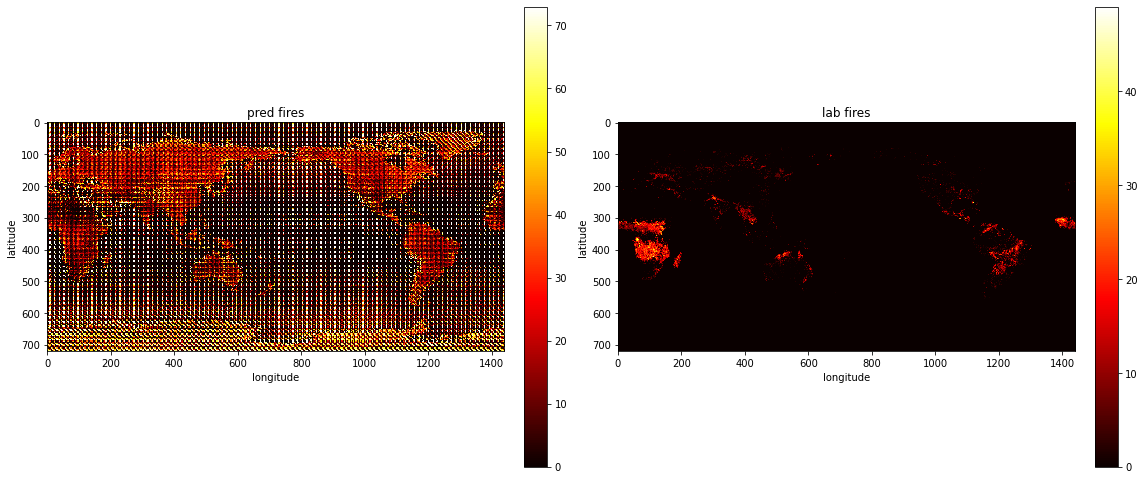

In [27]:

#plotting
fig, axes  = plt.subplots(1, 2, figsize = (16,8))
axes[0].imshow(pred_grid, cmap = 'hot', interpolation = 'nearest')
axes[0].set_title('pred fires')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(lab_grid, cmap = 'hot', interpolation = 'nearest')
axes[1].set_title('lab fires')
axes[1].set_xlabel('longitude')
axes[1].set_ylabel('latitude')
axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)


# plt.colorbar(label='Number of predictions')
plt.tight_layout()
plt.show()

In [36]:
torch.save(model.state_dict(), "aurora_fire_weights_all.pth")

### see aws id for missing line
# bucket_name = 'globfire-gooddata'
# s3.upload_file("aurora_fire_weights.pth", bucket_name, "aurora_fire_weights.pth")

In [ ]:
from aurora import Aurora

model = Aurora(
    use_lora=False,  # Model was not fine-tuned.
    autocast=True,  # Use AMP.
)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

batch = ...  # Load some data.

model = model.cuda()
model.train()
model.configure_activation_checkpointing()

pred = model.forward(batch)
loss = ...
loss.backward()

## trying to see if thing works with generic aah data 721 - 720 check


In [ ]:

static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(f"../{download_path}/fle/surf_2015-01-04.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(f"../{download_path}/atmospheric/201501/atmospheric_20150104.nc", engine="netcdf4")


i = 0  # Select this time index in the downloaded data.

batch3 = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i - 1, i]][None])
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i - 1, i]][None])
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [ ]:
i = 0  # Select this time index in the downloaded data.

batch4 = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

In [ ]:
from aurora import Aurora, rollout

model2 = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model2.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model2.eval()
model2 = model2.to("cuda")


In [ ]:

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model2, batch4, steps=2)]

model2 = model2.to("cpu")

# torch.stack(list(pred.surf_vars.values())).size()

In [ ]:
preds[1].surf_vars['2t'].size()